## 🐼 Data Analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

### Loading Data

In [2]:
PATH = 'synthetic_ride_hail_phnom_penh.csv'

data = pd.read_csv(PATH)
data.head()

,trip_id,date,dept_lat,dept_lon,arr_lat,arr_lon,vehicle_type,request_time,wait_time_min,trip_distance_km,est_time_min,actual_time_min,arr_time,fare_usd,surge_pricing,tip_usd,driver_rating,traffic_level,weather,estimated_CO2_g
0,1,2026-02-01,11.533592,104.875945,11.532852,104.872658,Rickshaw,06:39,7,5.09,17,30,07:09,2.33,1.0,1.32,5,Very High,Cloudy,392.27
1,2,2026-02-01,11.570388,104.868549,11.609510,104.965489,Remork,08:58,6,5.85,20,23,09:21,3.07,1.0,1.26,5,High,Clear,468.73
2,3,2026-02-01,11.530743,104.958590,11.602589,104.902785,Rickshaw,20:33,3,5.33,18,21,20:54,2.59,1.0,0.00,5,Medium,Clear,339.90
3,4,2026-02-01,11.553934,104.861142,11.540238,104.946489,Remork,08:40,9,2.45,8,11,08:51,1.74,1.3,0.58,5,Very High,Clear,204.04
4,5,2026-02-01,11.570571,104.888023,11.546010,104.924600,Remork,14:32,6,4.26,14,16,14:48,2.40,1.0,1.30,5,High,Cloudy,474.37


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2168 entries, 0 to 2167
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   trip_id           2168 non-null   int64  
 1   date              2168 non-null   object 
 2   dept_lat          2168 non-null   float64
 3   dept_lon          2168 non-null   float64
 4   arr_lat           2168 non-null   float64
 5   arr_lon           2168 non-null   float64
 6   vehicle_type      2168 non-null   object 
 7   request_time      2168 non-null   object 
 8   wait_time_min     2168 non-null   int64  
 9   trip_distance_km  2168 non-null   float64
 10  est_time_min      2168 non-null   int64  
 11  actual_time_min   2168 non-null   int64  
 12  arr_time          2168 non-null   object 
 13  fare_usd          2168 non-null   float64
 14  surge_pricing     2168 non-null   float64
 15  tip_usd           2168 non-null   float64
 16  driver_rating     2168 non-null   int64  


### Statistical Summary

In [4]:
coordinates = ['dept_lat', 'dept_lon', 'arr_lat', 'arr_lon']
all_quan_cols = data.select_dtypes(include='number').columns.tolist()
quan_cols = [col for col in all_quan_cols if col not in coordinates]
qual_cols = data.select_dtypes(exclude='number').columns.tolist()

print("Coordinate Columns:", coordinates)
print("Quantitative Columns:", quan_cols)
print("Qualitative Columns:", qual_cols)

Coordinate Columns: ['dept_lat', 'dept_lon', 'arr_lat', 'arr_lon']
Quantitative Columns: ['trip_id', 'wait_time_min', 'trip_distance_km', 'est_time_min', 'actual_time_min', 'fare_usd', 'surge_pricing', 'tip_usd', 'driver_rating', 'estimated_CO2_g']
Qualitative Columns: ['date', 'vehicle_type', 'request_time', 'arr_time', 'traffic_level', 'weather']


In [5]:
# Drop Trip ID and date
quan_cols.remove('trip_id')
print("trip_id has been removed from quan_cols")

qual_cols.remove('date')
print("date has been removed from qual_cols")

trip_id has been removed from quan_cols
date has been removed from qual_cols


In [6]:
# Classify request_time to time of day
from datetime import datetime

# calculate the hours into minutes
data_time_minutes = pd.to_datetime(data['request_time']).dt.hour * 60 + pd.to_datetime(data['request_time']).dt.minute

bins= [360, 540, 720, 900, 1080, 1260, 1440]
time_category = ['Morning', 'Late Morning', 'Afternoon', 'Late Afternoon', 'Evening', 'Night']
data_time = pd.cut(data_time_minutes, bins=bins, labels=time_category)

C:\Users\eungl\AppData\Local\Temp\ipykernel_18308\240546959.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data_time_minutes = pd.to_datetime(data['request_time']).dt.hour * 60 + pd.to_datetime(data['request_time']).dt.minute
C:\Users\eungl\AppData\Local\Temp\ipykernel_18308\240546959.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data_time_minutes = pd.to_datetime(data['request_time']).dt.hour * 60 + pd.to_datetime(data['request_time']).dt.minute


In [7]:
data_time.name = 'time_of_day'

| Label | Minutes | Time |
|-------|---------|------|
| Morning | 360 - 539 | 06:00 - 08:59 |
| Late Morning | 540 - 719 | 09:00 - 11:59 |
| Afternoon | 720 - 899 | 12:00 - 14:59 |
| Late Afternoon | 900 - 1079 | 15:00 - 17:59 |
| Evening | 1080 - 1259 | 18:00 - 20:59 |
| Night | 1260 - 1440 | 21:00 - 23:59 |

In [8]:
data = pd.concat([data, data_time], axis=1)

In [9]:
# initially, date is in string object, so gotta convert into datetime [D -> date specific] format, in order to apply np.is_busday 
is_weekday = np.is_busday(pd.to_datetime(data['date']).values.astype('datetime64[D]')).astype(int)
is_weekend = (~np.is_busday(pd.to_datetime(data['date']).values.astype('datetime64[D]'))).astype(int)

In [10]:
data['day'] = pd.to_datetime(data['date']).dt.day_name()

data['is_weekday'] = is_weekday
data['is_weekend'] = is_weekend

In [11]:
data.sample(5)

,trip_id,date,dept_lat,dept_lon,arr_lat,arr_lon,vehicle_type,request_time,wait_time_min,trip_distance_km,...,surge_pricing,tip_usd,driver_rating,traffic_level,weather,estimated_CO2_g,time_of_day,day,is_weekday,is_weekend
721,722,2026-02-10,11.588579,104.910488,11.528135,104.916210,EV Car,16:13,4,5.82,...,1.0,0.00,5,Low,Smog,11.36,Late Afternoon,Tuesday,1,0
455,456,2026-02-07,11.596959,104.962293,11.537068,104.959373,Rickshaw,17:39,7,5.76,...,1.5,0.00,5,Very High,Clear,350.80,Late Afternoon,Saturday,0,1
351,352,2026-02-05,11.588437,104.923914,11.592824,104.852572,Rickshaw,13:50,7,9.21,...,1.2,0.73,4,Very High,Clear,520.15,Afternoon,Thursday,1,0
703,704,2026-02-10,11.544300,104.960144,11.537589,104.875576,Motor Dup,14:56,4,3.67,...,1.2,0.00,5,Medium,Smog,244.09,Afternoon,Tuesday,1,0
356,357,2026-02-05,11.586899,104.963905,11.512041,104.881950,Rickshaw,08:17,5,8.14,...,1.5,0.00,5,High,Windy,615.04,Morning,Thursday,1,0


### 1. Descriptive

In [12]:
print("Quantitative Data Statistical Summary")
data[quan_cols].describe()

Quantitative Data Statistical Summary


,wait_time_min,trip_distance_km,est_time_min,actual_time_min,fare_usd,surge_pricing,tip_usd,driver_rating,estimated_CO2_g
count,2168.000000,2168.000000,2168.000000,2168.000000,2168.000000,2168.000000,2168.000000,2168.000000,2168.00000
mean,4.613007,6.011070,20.040129,23.541052,3.617744,1.190406,0.864234,4.383764,376.47720
std,2.187382,1.966546,6.559708,7.742342,1.686932,0.180217,1.704709,0.865881,229.94605
min,1.000000,0.500000,2.000000,1.000000,0.200000,1.000000,0.000000,1.000000,0.11000
25%,3.000000,4.707500,16.000000,18.000000,2.420000,1.000000,0.000000,4.000000,229.07750
50%,5.000000,5.970000,20.000000,23.000000,3.370000,1.200000,0.000000,5.000000,383.31000
75%,6.000000,7.342500,24.000000,29.000000,4.540000,1.300000,1.240000,5.000000,523.98250
max,13.000000,12.630000,42.000000,51.000000,13.150000,1.500000,9.980000,5.000000,1252.84000


In [13]:
qual_cols.remove('request_time')
qual_cols.remove('arr_time')
qual_cols.append('day')
qual_cols.append('time_of_day')

In [14]:
print("Qualitative Data Stastical Summary")

for var in qual_cols:
    # print(data[var].unique())
    print(f"Statistical Summary of {var}:\n")
    print(data[var].value_counts())

Qualitative Data Stastical Summary
Statistical Summary of vehicle_type:

vehicle_type
Rickshaw     1121
Remork        443
EV Car        376
Motor Dup     228
Name: count, dtype: int64
Statistical Summary of traffic_level:

traffic_level
High         811
Medium       540
Very High    460
Low          357
Name: count, dtype: int64
Statistical Summary of weather:

weather
Clear     1092
Cloudy     639
Smog       221
Windy      216
Name: count, dtype: int64
Statistical Summary of day:

day
Sunday       324
Wednesday    322
Friday       308
Thursday     307
Saturday     304
Tuesday      303
Monday       300
Name: count, dtype: int64
Statistical Summary of time_of_day:

time_of_day
Morning           553
Afternoon         457
Evening           427
Late Afternoon    369
Late Morning      275
Night              85
Name: count, dtype: int64


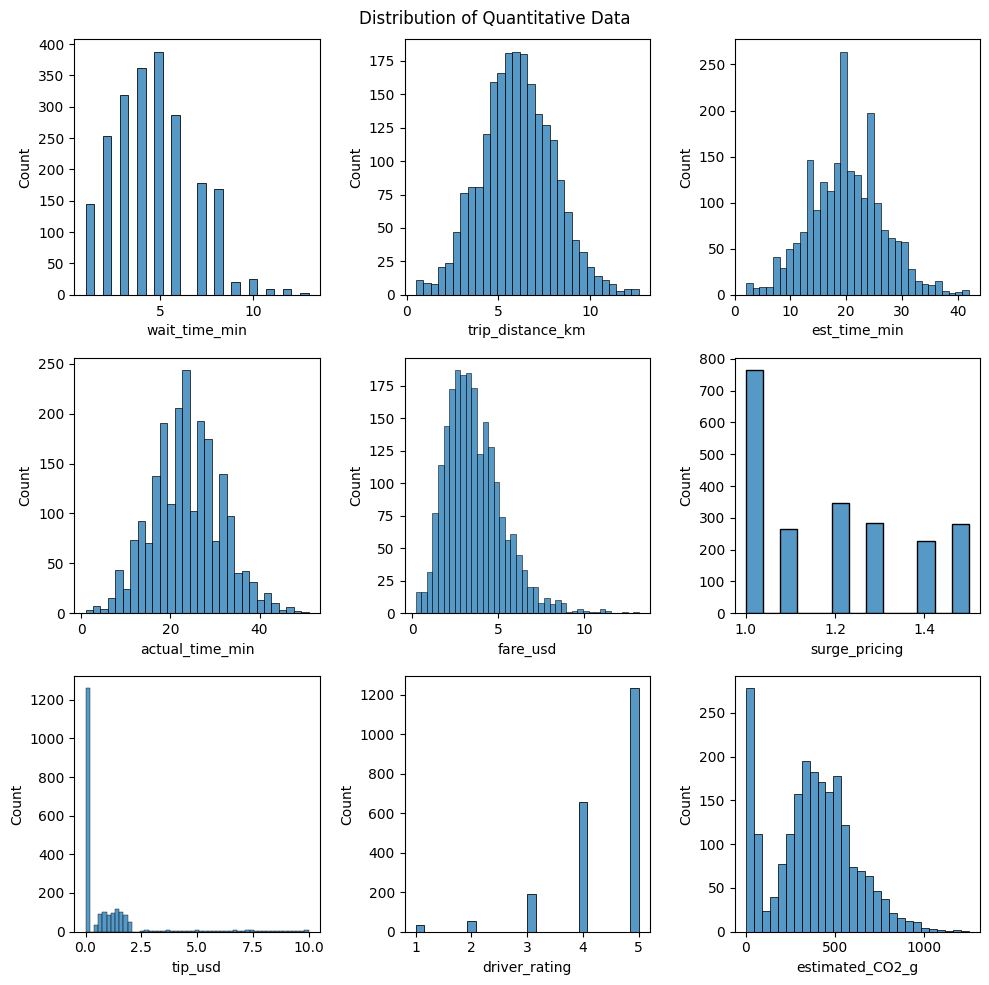

In [15]:
# Plot Quantitative Data
fig, ax = plt.subplots(3, 3, figsize=(10, 10))

for i, var in enumerate(quan_cols):
    row = i // 3
    col = i % 3
    sns.histplot(data=data, x=var, ax=ax[row, col])

plt.suptitle("Distribution of Quantitative Data")
plt.tight_layout()

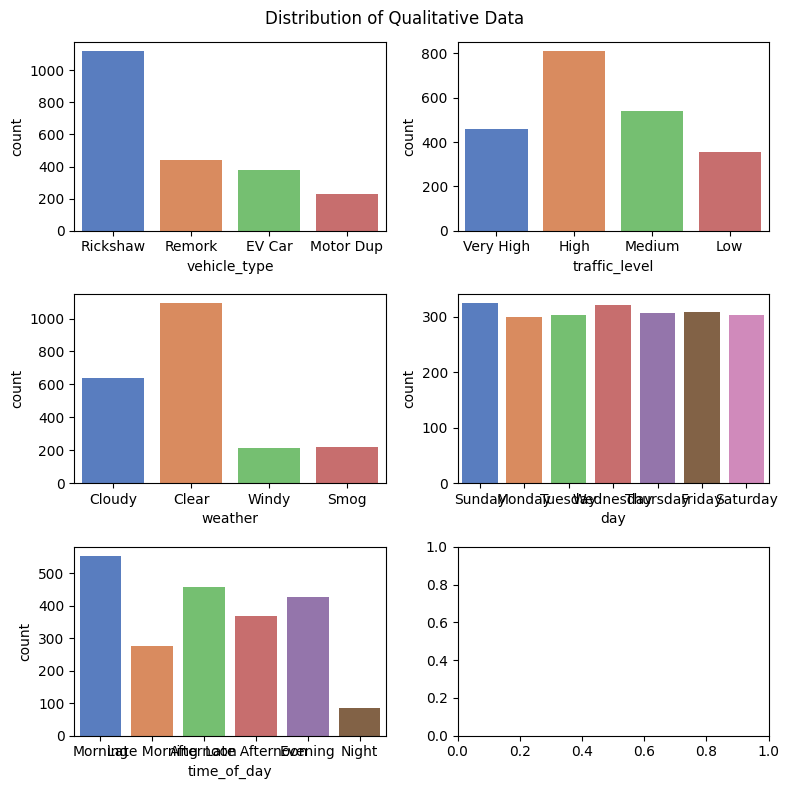

In [16]:
# Plot Qualtitative Data
fig, ax = plt.subplots(3, 2, figsize=(8, 8))

for i, var in enumerate(qual_cols):
    row = i // 2
    col = i % 2
    sns.countplot(data, x=var, ax=ax[row, col], hue=var, palette='muted', legend=False)

plt.suptitle("Distribution of Qualitative Data")
plt.tight_layout()

### 2. Diagnostic


### Questions for Diagnostic Analysis (Correlation & Hypothesis)

#### Quan vs Quan

                  trip_distance_km   tip_usd
trip_distance_km          1.000000  0.000977
tip_usd                   0.000977  1.000000


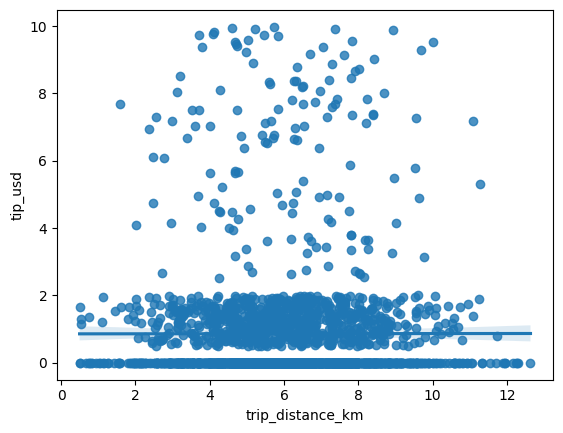

In [18]:
# Relationship between Distance and Tip
sns.regplot(data, x='trip_distance_km', y='tip_usd')

print(data[['trip_distance_km', 'tip_usd']].corr())


                 est_time_min  actual_time_min
est_time_min         1.000000         0.855914
actual_time_min      0.855914         1.000000


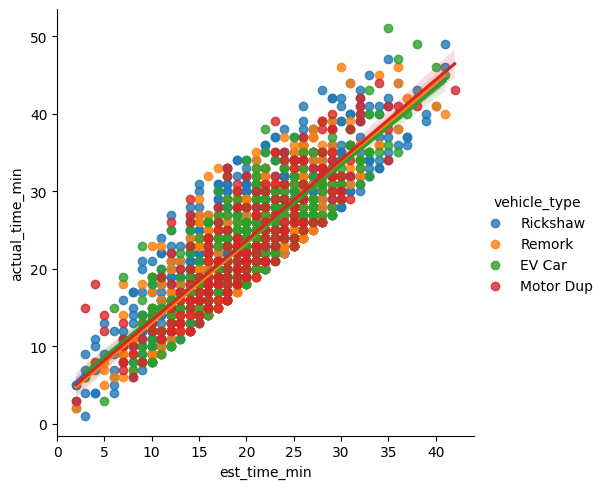

In [24]:
# Est and Actual Time
sns.lmplot(data, x='est_time_min', y='actual_time_min', hue='vehicle_type')
print(data[['est_time_min', 'actual_time_min']].corr())

                  trip_distance_km  fare_usd
trip_distance_km          1.000000  0.721787
fare_usd                  0.721787  1.000000


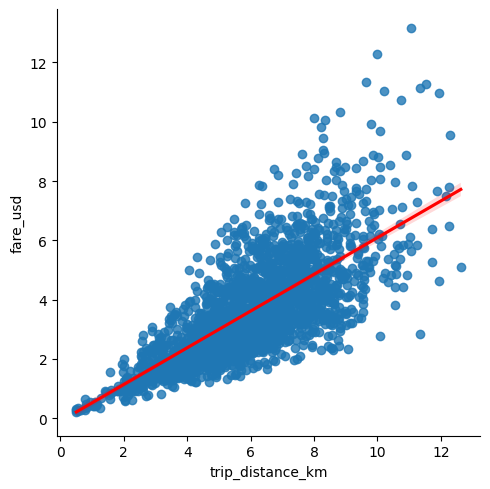

In [29]:
# Does trip distance affect actual time
sns.lmplot(
    data,
    x='trip_distance_km',
    y='fare_usd', 
    line_kws={'color': 'red'}
)

print(data[['trip_distance_km', 'fare_usd']].corr())

Based on the graph,

#### Quan vs Qual

<Axes: xlabel='weather', ylabel='actual_time_min'>

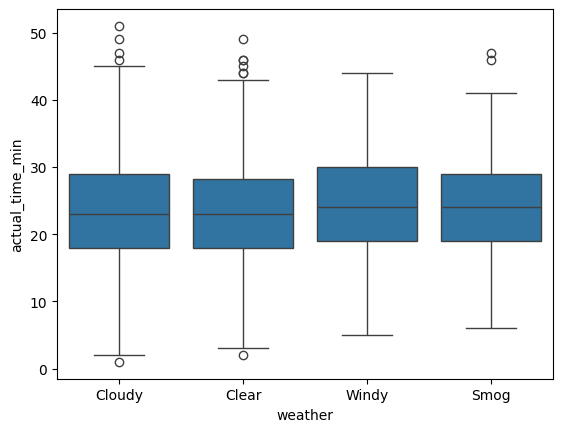

In [30]:
# Does weather condition affect actual ride time
sns.boxplot(data, x='weather', y='actual_time_min')

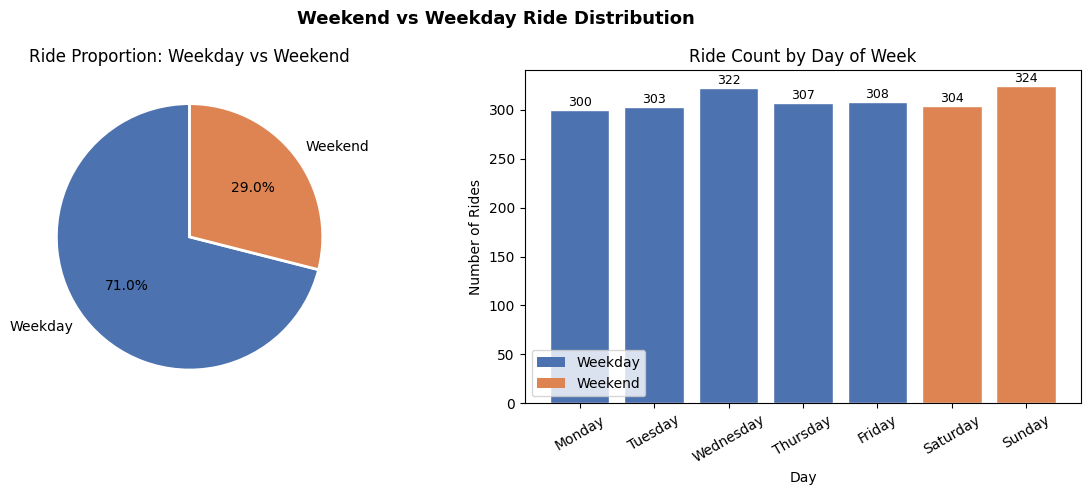

In [32]:

# Does weekend and weekday have different ride proportion?

day_name = pd.to_datetime(data['date']).dt.day_name()

weekend_days = ['Saturday', 'Sunday']
day_type = day_name.apply(lambda d: 'Weekend' if d in weekend_days else 'Weekday')

day_type_counts = day_type.value_counts()

day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_counts = day_name.value_counts().reindex(day_order).fillna(0)
day_colors = ['#4C72B0'] * 5 + ['#DD8452'] * 2  # blue = weekday, orange = weekend

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# --- Left: Pie chart (overall proportion) ---
axes[0].pie(
    day_type_counts,
    labels=day_type_counts.index,
    autopct='%1.1f%%',
    colors=['#4C72B0', '#DD8452'],
    startangle=90,
    wedgeprops=dict(edgecolor='white', linewidth=2)
)
axes[0].set_title('Ride Proportion: Weekday vs Weekend')

# --- Right: Bar chart per day (count per day, colored by type) ---
bars = axes[1].bar(day_counts.index, day_counts.values, color=day_colors, edgecolor='white')
axes[1].set_title('Ride Count by Day of Week')
axes[1].set_xlabel('Day')
axes[1].set_ylabel('Number of Rides')
axes[1].tick_params(axis='x', rotation=30)

for bar in bars:
    axes[1].text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 1,
        f'{int(bar.get_height())}',
        ha='center', va='bottom', fontsize=9
    )

from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='#4C72B0', label='Weekday'),
                   Patch(facecolor='#DD8452', label='Weekend')]
axes[1].legend(handles=legend_elements)

plt.suptitle('Weekend vs Weekday Ride Distribution', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()


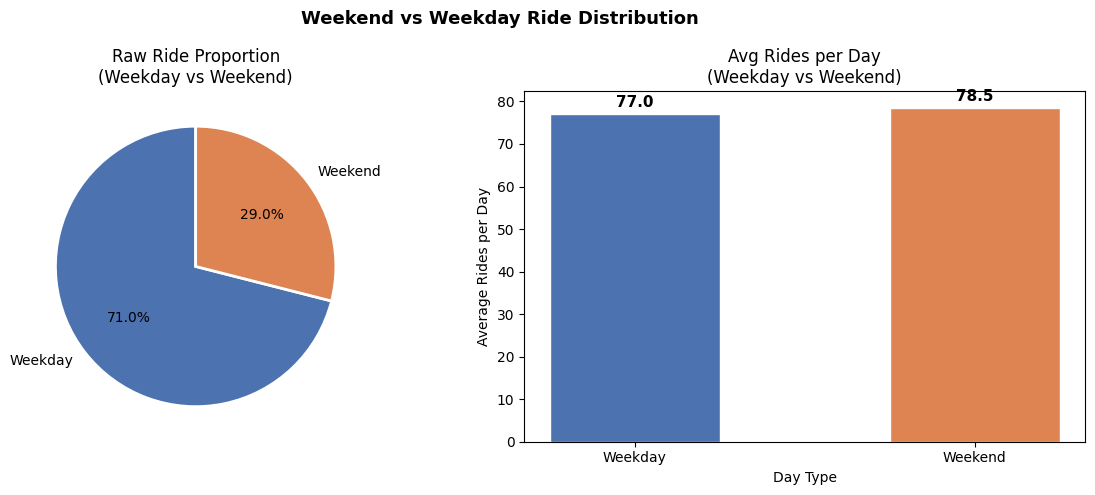


--- Average Rides Per Day ---
date
Weekday    77.0
Weekend    78.5
dtype: float64


In [88]:
# Does weekend and weekday have different ride proportion (normalized per day)?

day_name = pd.to_datetime(data['date']).dt.day_name()
weekend_days = ['Saturday', 'Sunday']
day_type = day_name.apply(lambda d: 'Weekend' if d in weekend_days else 'Weekday')

# Count total rides per type
day_type_counts = day_type.value_counts()

# Count number of unique days per type
unique_days = pd.DataFrame({'day_name': day_name, 'day_type': day_type, 'date': data['date']})
num_days_per_type = unique_days.drop_duplicates('date').groupby('day_type')['date'].count()

# Average rides per day (normalized)
avg_rides = day_type_counts / num_days_per_type
avg_rides = avg_rides.reindex(['Weekday', 'Weekend'])

colors = ['#4C72B0', '#DD8452']

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# --- Left: Pie chart (raw proportion) ---
axes[0].pie(
    day_type_counts,
    labels=day_type_counts.index,
    autopct='%1.1f%%',
    colors=colors,
    startangle=90,
    wedgeprops=dict(edgecolor='white', linewidth=2)
)
axes[0].set_title('Raw Ride Proportion\n(Weekday vs Weekend)')

# --- Right: Avg rides per day (normalized) ---
bars = axes[1].bar(
    avg_rides.index,
    avg_rides.values,
    color=colors,
    edgecolor='white',
    width=0.5
)
axes[1].set_title('Avg Rides per Day\n(Weekday vs Weekend)')
axes[1].set_xlabel('Day Type')
axes[1].set_ylabel('Average Rides per Day')

for bar in bars:
    axes[1].text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 1,
        f'{bar.get_height():.1f}',
        ha='center', va='bottom', fontsize=11, fontweight='bold'
    )

plt.suptitle('Weekend vs Weekday Ride Distribution', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n--- Average Rides Per Day ---")
print(avg_rides.round(2))

<Axes: xlabel='surge_pricing', ylabel='fare_usd'>

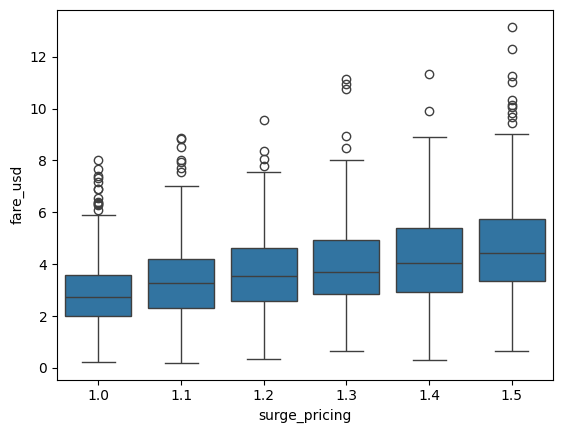

In [26]:
# Does surge pricing affect rating
sns.boxplot(data, x='surge_pricing', y='fare_usd')

In [27]:
# Does time of day affect fare or trip distance?

In [91]:
# Polar Plot of Request Time by Vehicle Type
import plotly.io as pio

# Extract hour from request_time
data_polar = data.copy()
data_polar['hour'] = pd.to_datetime(data_polar['request_time']).dt.hour

# Group by hour and vehicle type
polar_data = data_polar.groupby(['hour', 'vehicle_type'])['trip_id'].count().reset_index()
polar_data.columns = ['hour', 'vehicle_type', 'count']

hours_shown = list(range(0, 24))

fig = go.Figure()

for vehicle in polar_data['vehicle_type'].unique():
    df_v = polar_data[polar_data['vehicle_type'] == vehicle]

    # Build a full hour->count dict, default 0 for missing hours
    hour_count = dict(zip(df_v['hour'], df_v['count']))
    r     = [hour_count.get(h, 0) for h in hours_shown]
    theta = [h * (360 / 24) for h in hours_shown]

    # Close the shape by repeating first point
    r     = r + [r[0]]
    theta = theta + [theta[0]]

    fig.add_trace(go.Scatterpolar(
        r       = r,
        theta   = theta,
        mode    = 'lines',
        name    = vehicle,
        fill    = 'toself',
        opacity = 0.5,
        line    = dict(width=2),
    ))

fig.update_layout(
    title = 'Ride Requests by Hour of Day & Vehicle Type',
    polar = dict(
        angularaxis = dict(
            tickmode  = 'array',
            tickvals  = [h * (360 / 24) for h in hours_shown],
            ticktext  = [f"{h:02d}:00" for h in hours_shown],
            direction = 'clockwise',
            rotation  = 90,   # 00:00 starts at top
        ),
        radialaxis = dict(showticklabels=True),
    ),
    showlegend = True,
    legend     = dict(title='Vehicle Type'),
)

fig.show()
pio.write_html(fig, file='polar_ride_by_hour.html', auto_open=False)

C:\Users\eungl\AppData\Local\Temp\ipykernel_27136\3398577527.py:6: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.



In [92]:
# Polar Bar Chart of Request Time by Vehicle Type

# Extract hour from request_time
data_polar = data.copy()
data_polar['hour'] = pd.to_datetime(data_polar['request_time']).dt.hour

# Filter to only 6:00 - 23:00
data_polar = data_polar[data_polar['hour'] >= 6]

# Group by hour and vehicle type
polar_data = data_polar.groupby(['hour', 'vehicle_type'])['trip_id'].count().reset_index()
polar_data.columns = ['hour', 'vehicle_type', 'count']

hours_shown = list(range(6, 24))

fig = go.Figure()

for vehicle in polar_data['vehicle_type'].unique():
    df_v = polar_data[polar_data['vehicle_type'] == vehicle]

    fig.add_trace(go.Barpolar(
        r       = df_v['count'],
        theta   = [f"{h:02d}:00" for h in df_v['hour']],
        name    = vehicle,
        opacity = 0.7,
    ))

fig.update_layout(
    title  = 'Ride Requests by Hour of Day & Vehicle Type',
    polar  = dict(
        angularaxis = dict(
            tickmode  = 'array',
            tickvals  = [f"{h:02d}:00" for h in hours_shown],
            ticktext  = [f"{h:02d}:00" for h in hours_shown],
            direction = 'clockwise',
            rotation  = 90,
        )
    ),
    barmode    = 'overlay',
    showlegend = True,
    legend     = dict(title='Vehicle Type'),
)

fig.show()
pio.write_html(fig, file='polar_filled_ride_by_hour.html', auto_open=False)

C:\Users\eungl\AppData\Local\Temp\ipykernel_27136\844481223.py:5: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.



In [ ]:
# Line Series of Ride Requests by Hour of Day & Vehicle Type (Plotly)

# Extract hour from request_time and filter 6:00 - 23:00
data_line = data.copy()
data_line['hour'] = pd.to_datetime(data_line['request_time']).dt.hour
data_line = data_line[data_line['hour'] >= 6]

# Group by hour AND vehicle type
trip_by_hour_vehicle = data_line.groupby(['hour', 'vehicle_type'])['trip_id'].count().reset_index()
trip_by_hour_vehicle.columns = ['hour', 'vehicle_type', 'count']

fig = go.Figure()

for vehicle in trip_by_hour_vehicle['vehicle_type'].unique():
    df_v = trip_by_hour_vehicle[trip_by_hour_vehicle['vehicle_type'] == vehicle]

    fig.add_trace(go.Scatter(
        x       = [f"{h:02d}:00" for h in df_v['hour']],
        y       = df_v['count'],
        mode    = 'lines+markers',
        marker  = dict(size=6),
        line    = dict(width=2),
        name    = vehicle,
    ))

fig.update_layout(
    title  = 'Ride Requests by Hour of Day & Vehicle Type',
    xaxis  = dict(
        title     = 'Hour of Day',
        tickangle = -45,
    ),
    yaxis  = dict(title = 'Number of Rides'),
    legend = dict(title = 'Vehicle Type'),
)

fig.show()

pio.write_html(fig, file='time_series.html', auto_open=False)

C:\Users\eungl\AppData\Local\Temp\ipykernel_27136\1557945026.py:6: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.



In [78]:
# Line Series of Ride Requests by Hour of Day & Vehicle Type — Normalized (Plotly)
import plotly.graph_objects as go

# Extract hour from request_time and filter 6:00 - 23:00
data_line_norm = data.copy()
data_line_norm['hour'] = pd.to_datetime(data_line_norm['request_time']).dt.hour
data_line_norm = data_line_norm[data_line_norm['hour'] >= 6]

# Group by hour AND vehicle type
trip_norm = data_line_norm.groupby(['hour', 'vehicle_type'])['trip_id'].count().reset_index()
trip_norm.columns = ['hour', 'vehicle_type', 'count']

# Normalize each vehicle type to 0–1
trip_norm['count_norm'] = trip_norm.groupby('vehicle_type')['count'].transform(
    lambda x: (x - x.min()) / (x.max() - x.min())
)

fig = go.Figure()

for vehicle in trip_norm['vehicle_type'].unique():
    df_v = trip_norm[trip_norm['vehicle_type'] == vehicle]

    fig.add_trace(go.Scatter(
        x       = [f"{h:02d}:00" for h in df_v['hour']],
        y       = df_v['count_norm'],
        mode    = 'lines+markers',
        marker  = dict(size=6),
        line    = dict(width=2),
        name    = vehicle,
    ))

fig.update_layout(
    title  = 'Ride Request Pattern by Hour of Day & Vehicle Type (Normalized)',
    xaxis  = dict(
        title     = 'Hour of Day',
        tickangle = -45,
    ),
    yaxis  = dict(
        title      = 'Normalized Ride Requests (0–1)',
        range      = [0, 1],
        tickformat = '.1f',
    ),
    legend = dict(title = 'Vehicle Type'),
)

fig.show()

pio.write_html(fig, file='normalized_time_series.html', auto_open=False)

C:\Users\eungl\AppData\Local\Temp\ipykernel_27136\691113230.py:6: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.



             Eta-Squared (η²) Summary — Qual vs Quan             
Qualitative          Quantitative               η²   p-value  Sig?
-----------------------------------------------------------------
weather              fare_usd               0.0007    0.6824  ❌
weather              actual_time_min        0.0019    0.2476  ❌
weather              trip_distance_km       0.0005    0.7719  ❌
weather              tip_usd                 0.001    0.5322  ❌
weather              est_time_min           0.0005    0.7709  ❌
vehicle_type         fare_usd               0.2836       0.0  ✅
vehicle_type         actual_time_min        0.0006    0.7543  ❌
vehicle_type         trip_distance_km       0.0012    0.4639  ❌
vehicle_type         tip_usd                0.0023    0.1741  ❌
vehicle_type         est_time_min           0.0011    0.4929  ❌
surge_pricing        fare_usd               0.1446       0.0  ✅
surge_pricing        actual_time_min        0.0267       0.0  ✅
surge_pricing        trip_distanc

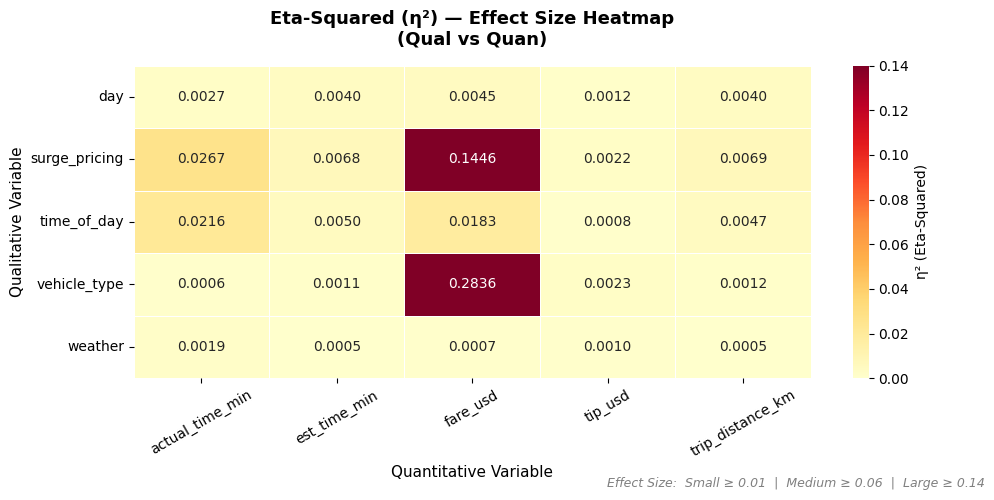

In [34]:
import pingouin as pg
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Define pairs ---
qual_eta = ['weather', 'vehicle_type', 'surge_pricing', 'time_of_day', 'day']
quan_eta = ['fare_usd', 'actual_time_min', 'trip_distance_km', 'tip_usd', 'est_time_min']

# --- Compute η² for all pairs ---
results = []

for q_cat in qual_eta:
    for q_num in quan_eta:
        try:
            aov = pg.anova(data=data, dv=q_num, between=q_cat, effsize='n2')
            eta2 = aov['n2'].values[0]
            p_val = aov['p-unc'].values[0]
            results.append({
                'Qualitative': q_cat,
                'Quantitative': q_num,
                'eta2': round(eta2, 4),
                'p_value': round(p_val, 4),
                'significant': '✅' if p_val < 0.05 else '❌'
            })
        except Exception as e:
            results.append({
                'Qualitative': q_cat,
                'Quantitative': q_num,
                'eta2': None,
                'p_value': None,
                'significant': '⚠️'
            })

df_eta = pd.DataFrame(results)

# --- Print Summary Table ---
print("=" * 65)
print(f"{'Eta-Squared (η²) Summary — Qual vs Quan':^65}")
print("=" * 65)
print(f"{'Qualitative':<20} {'Quantitative':<22} {'η²':>6}  {'p-value':>8}  {'Sig?'}")
print("-" * 65)

for _, row in df_eta.iterrows():
    print(f"{row['Qualitative']:<20} {row['Quantitative']:<22} {str(row['eta2']):>6}  {str(row['p_value']):>8}  {row['significant']}")

print("=" * 65)
print("Effect Size Guide:  Small ≥ 0.01 | Medium ≥ 0.06 | Large ≥ 0.14")
print("=" * 65)

# --- Heatmap ---
heatmap_data = df_eta.pivot(index='Qualitative', columns='Quantitative', values='eta2').astype(float)

fig, ax = plt.subplots(figsize=(10, 5))

sns.heatmap(
    heatmap_data,
    annot=True,
    fmt='.4f',
    cmap='YlOrRd',
    linewidths=0.5,
    linecolor='white',
    ax=ax,
    cbar_kws={'label': 'η² (Eta-Squared)'},
    vmin=0,
    vmax=0.14
)

ax.set_title('Eta-Squared (η²) — Effect Size Heatmap\n(Qual vs Quan)', 
             fontsize=13, fontweight='bold', pad=15)
ax.set_xlabel('Quantitative Variable', fontsize=11)
ax.set_ylabel('Qualitative Variable', fontsize=11)
ax.tick_params(axis='x', rotation=30)
ax.tick_params(axis='y', rotation=0)

# Add effect size legend as text
fig.text(0.99, 0.01,
         'Effect Size:  Small ≥ 0.01  |  Medium ≥ 0.06  |  Large ≥ 0.14',
         ha='right', va='bottom', fontsize=9, color='gray', style='italic')

plt.tight_layout()
plt.show()

C:\Users\eungl\AppData\Local\Temp\ipykernel_18308\2466808499.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


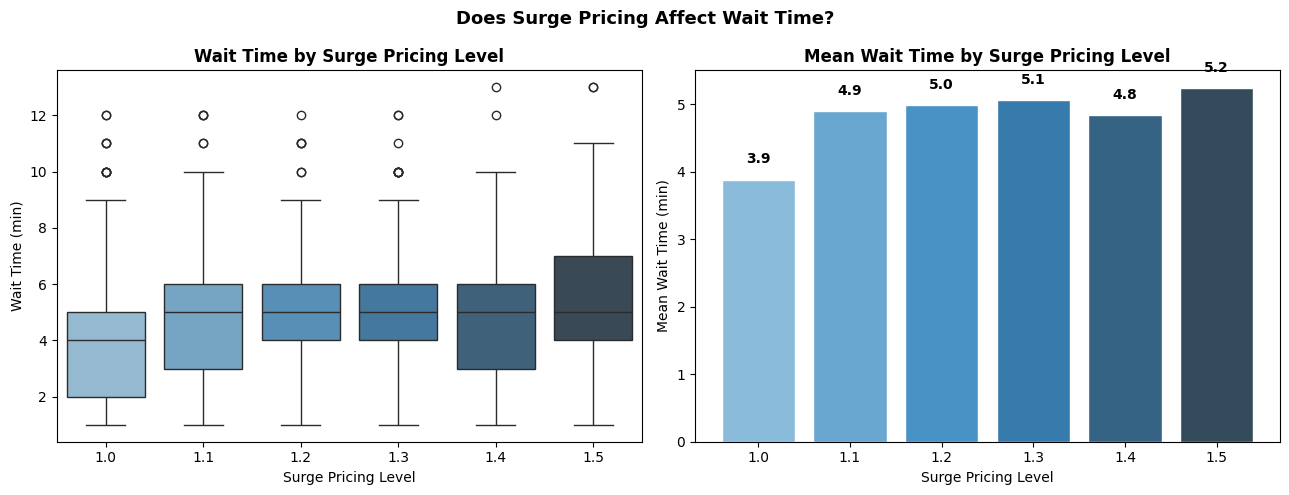

In [35]:
# Does surge pricing affect wait time?

fig, axes = plt.subplots(1, 2, figsize=(13, 5))

surge_levels = sorted(data['surge_pricing'].unique())
palette = sns.color_palette('Blues_d', len(surge_levels))

# --- Left: Boxplot ---
sns.boxplot(
    data=data,
    x='surge_pricing',
    y='wait_time_min',
    palette=palette,
    order=surge_levels,
    ax=axes[0]
)
axes[0].set_title('Wait Time by Surge Pricing Level', fontweight='bold')
axes[0].set_xlabel('Surge Pricing Level')
axes[0].set_ylabel('Wait Time (min)')

# --- Right: Mean bar chart ---
mean_wait = data.groupby('surge_pricing')['wait_time_min'].mean().sort_index()

bars = axes[1].bar(
    mean_wait.index.astype(str),
    mean_wait.values,
    color=palette,
    edgecolor='white'
)
axes[1].set_title('Mean Wait Time by Surge Pricing Level', fontweight='bold')
axes[1].set_xlabel('Surge Pricing Level')
axes[1].set_ylabel('Mean Wait Time (min)')

for bar in bars:
    axes[1].text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 0.2,
        f'{bar.get_height():.1f}',
        ha='center', va='bottom', fontsize=10, fontweight='bold'
    )

plt.suptitle('Does Surge Pricing Affect Wait Time?', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

C:\Users\eungl\AppData\Local\Temp\ipykernel_18308\1518591357.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


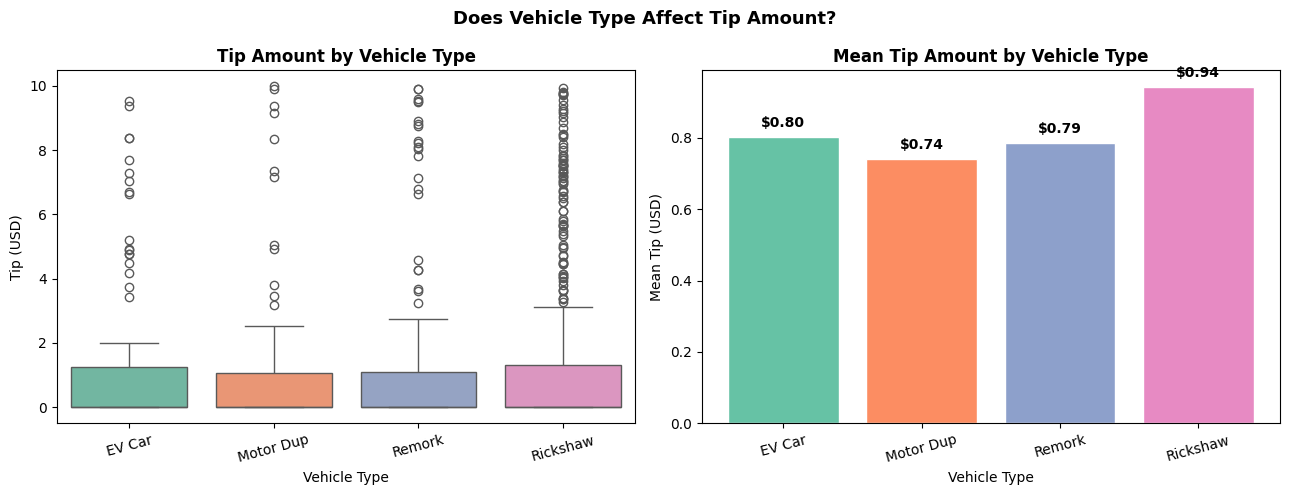

  ANOVA — Vehicle Type vs Tip (USD)
  p-value          : 0.1741
  η² (Eta-Squared) : 0.0023
  Significant      : ❌ No
--------------------------------------------------
  Effect Size      : Negligible (η² = 0.0023)


In [36]:
# Does vehicle type affect tip amount?

fig, axes = plt.subplots(1, 2, figsize=(13, 5))

vehicle_order = sorted(data['vehicle_type'].unique())
palette = sns.color_palette('Set2', len(vehicle_order))

# --- Left: Boxplot ---
sns.boxplot(
    data=data,
    x='vehicle_type',
    y='tip_usd',
    order=vehicle_order,
    palette=palette,
    ax=axes[0]
)
axes[0].set_title('Tip Amount by Vehicle Type', fontweight='bold')
axes[0].set_xlabel('Vehicle Type')
axes[0].set_ylabel('Tip (USD)')
axes[0].tick_params(axis='x', rotation=15)

# --- Right: Mean bar chart ---
mean_tip = data.groupby('vehicle_type')['tip_usd'].mean().reindex(vehicle_order)

bars = axes[1].bar(
    mean_tip.index,
    mean_tip.values,
    color=palette,
    edgecolor='white'
)
axes[1].set_title('Mean Tip Amount by Vehicle Type', fontweight='bold')
axes[1].set_xlabel('Vehicle Type')
axes[1].set_ylabel('Mean Tip (USD)')
axes[1].tick_params(axis='x', rotation=15)

for bar in bars:
    axes[1].text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 0.02,
        f'${bar.get_height():.2f}',
        ha='center', va='bottom', fontsize=10, fontweight='bold'
    )

plt.suptitle('Does Vehicle Type Affect Tip Amount?', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

# --- ANOVA + Eta-Squared ---
aov = pg.anova(data=data, dv='tip_usd', between='vehicle_type', effsize='n2')

eta2 = aov['n2'].values[0]
p_val = aov['p-unc'].values[0]

print("=" * 50)
print(f"  ANOVA — Vehicle Type vs Tip (USD)")
print("=" * 50)
print(f"  p-value          : {p_val:.4f}")
print(f"  η² (Eta-Squared) : {eta2:.4f}")
print(f"  Significant      : {'✅ Yes' if p_val < 0.05 else '❌ No'}")
print("-" * 50)

if eta2 >= 0.14:
    effect = "Large"
elif eta2 >= 0.06:
    effect = "Medium"
elif eta2 >= 0.01:
    effect = "Small"
else:
    effect = "Negligible"

print(f"  Effect Size      : {effect} (η² = {eta2:.4f})")
print("=" * 50)

C:\Users\eungl\AppData\Local\Temp\ipykernel_27136\3389234772.py:6: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




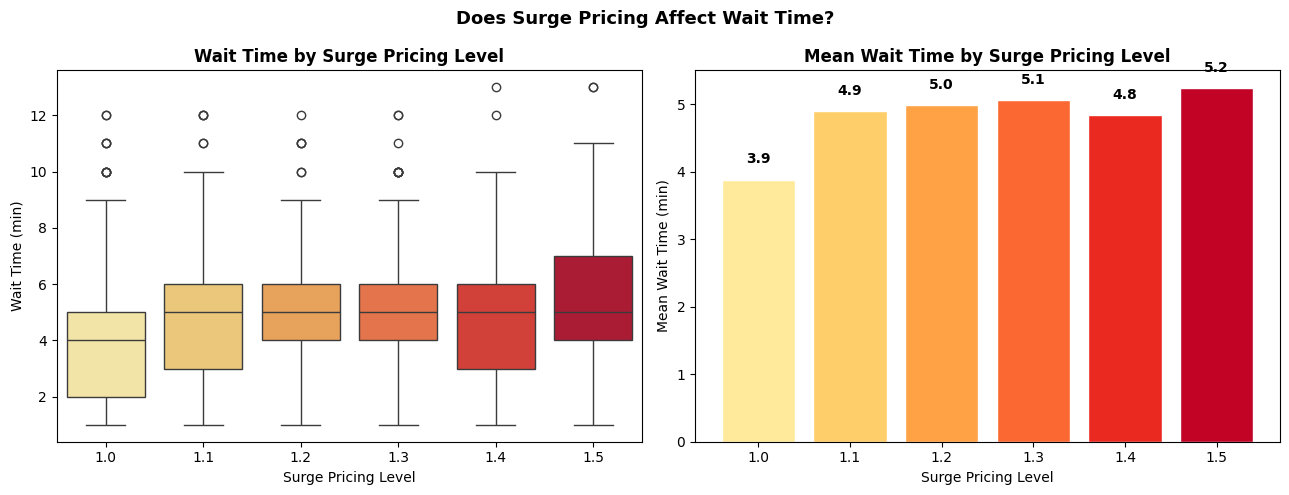

  ANOVA — Surge Pricing vs Wait Time (min)
  η² (Eta-Squared) : 0.0636
  p-value          : 0.0000
  Significant      : ✅ Yes
--------------------------------------------------
  Effect Size      : Medium (η² = 0.0636)


In [99]:
# Does surge pricing affect wait time?

fig, axes = plt.subplots(1, 2, figsize=(13, 5))

# --- Left: Boxplot ---
sns.boxplot(
    data=data,
    x='surge_pricing',
    y='wait_time_min',
    palette='YlOrRd',
    order=sorted(data['surge_pricing'].unique()),
    ax=axes[0]
)
axes[0].set_title('Wait Time by Surge Pricing Level', fontweight='bold')
axes[0].set_xlabel('Surge Pricing Level')
axes[0].set_ylabel('Wait Time (min)')

# --- Right: Mean bar chart ---
mean_wait = data.groupby('surge_pricing')['wait_time_min'].mean().sort_index()

bars = axes[1].bar(
    mean_wait.index.astype(str),
    mean_wait.values,
    color=sns.color_palette('YlOrRd', len(mean_wait)),
    edgecolor='white'
)
axes[1].set_title('Mean Wait Time by Surge Pricing Level', fontweight='bold')
axes[1].set_xlabel('Surge Pricing Level')
axes[1].set_ylabel('Mean Wait Time (min)')

for bar in bars:
    axes[1].text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 0.2,
        f'{bar.get_height():.1f}',
        ha='center', va='bottom', fontsize=10, fontweight='bold'
    )

plt.suptitle('Does Surge Pricing Affect Wait Time?', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

# --- ANOVA + Eta-Squared ---
aov = pg.anova(data=data, dv='wait_time_min', between='surge_pricing', effsize='n2')

eta2 = aov['n2'].values[0]
p_val = aov['p-unc'].values[0]

print("=" * 50)
print(f"  ANOVA — Surge Pricing vs Wait Time (min)")
print("=" * 50)
print(f"  η² (Eta-Squared) : {eta2:.4f}")
print(f"  p-value          : {p_val:.4f}")
print(f"  Significant      : {'✅ Yes' if p_val < 0.05 else '❌ No'}")
print("-" * 50)

if eta2 >= 0.14:
    effect = "Large"
elif eta2 >= 0.06:
    effect = "Medium"
elif eta2 >= 0.01:
    effect = "Small"
else:
    effect = "Negligible"

print(f"  Effect Size      : {effect} (η² = {eta2:.4f})")
print("=" * 50)